This notebook does 2 things:

1. Applies different resenet architectures and selects the
   model and architecture based on the validation loss.

1. Calculates AUC ROC score fo the best model.

In [40]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from fastai2.metrics import RocAuc
from fastai2.vision.all import *

from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(42)

from torch.nn import CrossEntropyLoss

In [41]:
df = pd.read_csv('data/train.csv')

In [42]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [45]:
y_train, y_test = train_test_split(df.target, random_state=42, 
                                   test_size=0.33)

train_pos_indexes = y_train[y_train==1].index

train_neg_indexes = np.random.choice(y_train[y_train==0].index,384*5)

df['purpose'] = np.nan

df.loc[y_test.index.tolist() ,'purpose'] = 'val'
df.loc[train_pos_indexes, 'purpose' ] = 'train'
df.loc[train_neg_indexes, 'purpose' ] = 'train'

def custom_splitter(df):
    train = df.index[df.purpose=='train'].tolist()
    val   = df.index[df.purpose=='val'].tolist()

    return train, val

In [46]:
dblock = DataBlock((ImageBlock, CategoryBlock),
                   splitter = custom_splitter,
                   get_x = lambda r: f"data/jpeg/train-224/{r['image_name']}.jpg",
                   get_y = lambda r : str(r["target"]),
                   item_tfms = None)


dls = dblock.dataloaders(df,bs=32, num_workers = 0)
dls_large = dblock.dataloaders(df,bs=256, num_workers = 0)

In [98]:
cross_entropy_loss = CrossEntropyLoss()

In [70]:
weighted_cross_entropy_loss = CrossEntropyLoss(weight=torch.tensor([1,10],dtype=torch.float,
                                                         device='cuda:0'),
                                reduction = 'mean' )

In [58]:
learn = cnn_learner(dls, resnet18,metrics = [accuracy, RocAuc()],
                   loss=weighted_cross_entropy_loss)

In [59]:
x,y = dls.one_batch()

In [84]:
activs = learn.model(x)

In [ ]:
for idx in range(32):
    loss = cross_entropy_loss(activs[idx:idx+1], y[idx:idx+1])
    print(activs[idx:idx+1], y[idx:idx+1], loss)

In [99]:
learn = cnn_learner(dls, resnet18,metrics = [accuracy, RocAuc()],
                   loss=cross_entropy_loss)


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=3.981071586167673e-06)

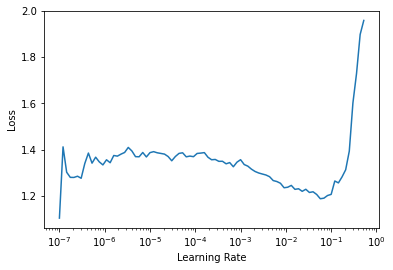

In [100]:
learn.lr_find()

In [105]:
learn = cnn_learner(dls_large, resnet18,metrics = [accuracy, RocAuc()],
                   loss=cross_entropy_loss)


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.013182567432522774)

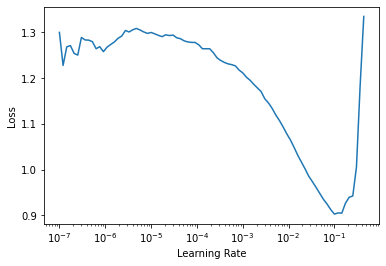

In [102]:
learn.lr_find()

In [106]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.160567,0.256542,0.916850,0.626440,00:36
1,0.856216,0.287630,0.896817,0.628504,00:36
2,0.673215,0.317198,0.878522,0.675614,00:36


In [107]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.335832,0.285584,0.900476,0.706423,00:36
1,0.293788,0.408381,0.873399,0.729433,00:36
2,0.249883,0.361856,0.884559,0.710583,00:36


In [108]:
learn.save('resnet18-v1')

In [109]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.166786,0.329648,0.887395,0.682587,00:36
1,0.156534,0.219213,0.934687,0.628164,00:36
2,0.150816,0.270615,0.918588,0.654312,00:36


In [111]:
learn.load('resnet18-v1')

In [112]:
learn.unfreeze()

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=7.585775892948732e-05)

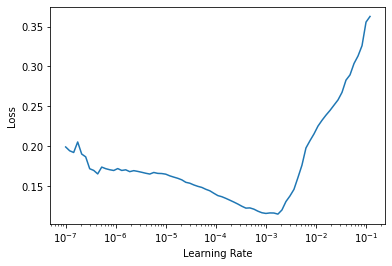

In [113]:
learn.lr_find()

In [114]:
learn.fit_one_cycle(10, slice(1e-5,3e-3))

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.160601,0.241029,0.919777,0.674545,00:37
1,0.129395,0.342450,0.891969,0.692276,00:37
2,0.099663,0.284778,0.917947,0.651533,00:37
3,0.079081,1.027512,0.815770,0.734430,00:37
4,0.068702,0.319132,0.933315,0.664267,00:38
5,0.059070,0.311481,0.932309,0.666208,00:37
6,0.049216,0.520871,0.896634,0.692199,00:37
7,0.040445,0.450806,0.907977,0.697976,00:37
8,0.033682,0.412436,0.915203,0.691843,00:37
9,0.028222,0.387282,0.918679,0.686253,00:37


## Focal Loss

In [123]:
learn = cnn_learner(dls_large, resnet18,metrics = [accuracy, RocAuc()],
                   loss=FocalLoss(gamma=2, alpha = [1,10]) )

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.013182567432522774)

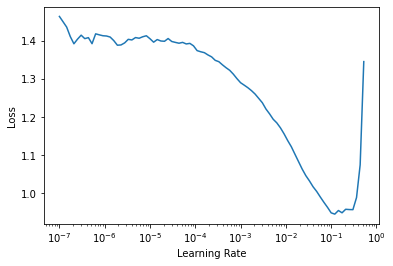

In [124]:
learn.lr_find()

In [119]:
learn.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.281426,0.575158,0.742042,0.674798,00:36
1,1.099322,0.360611,0.853732,0.702243,00:36
2,0.986943,0.467511,0.802415,0.720267,00:36
3,0.899617,0.502385,0.791072,0.726757,00:36
4,0.820324,0.504573,0.794548,0.735888,00:36
5,0.766406,0.512165,0.787505,0.732301,00:36


In [120]:
learn.unfreeze()

SuggestedLRs(lr_min=0.00036307806149125097, lr_steep=0.0005754399462603033)

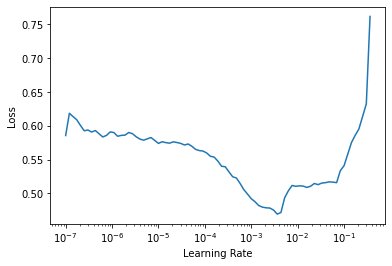

In [121]:
learn.lr_find()

In [122]:
learn.fit_one_cycle(10, slice(1e-4, 6e-2))

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.732298,1.506871,0.558178,0.637581,00:38
1,0.661336,12.319986,0.497256,0.699782,00:38
2,0.707511,2.137377,0.683589,0.667108,00:38
3,0.652244,2.051779,0.757135,0.684939,00:37
4,0.571468,0.691209,0.840743,0.747149,00:38
5,0.492576,0.535879,0.911178,0.733955,00:37
6,0.415471,0.811111,0.826473,0.774228,00:37
7,0.349657,0.287133,0.930205,0.694577,00:37
8,0.289958,0.204621,0.947677,0.661768,00:38
9,0.244163,0.223016,0.941365,0.665913,00:37


## dice loss

In [24]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self,pred, target):
        smooth = 1.
        iflat = pred.contiguous().view(-1)
        tflat = target.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [25]:
learn = cnn_learner(dls, resnet18,metrics = [accuracy, RocAuc()],
                   loss=diceloss())

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=9.12010818865383e-07)

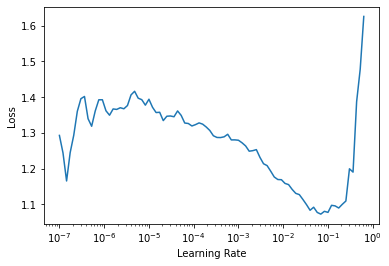

In [26]:
learn.lr_find()

In [28]:
learn.dls = dls_large

In [29]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.230057,0.097563,0.975393,0.523773,00:42
1,0.218129,0.108292,0.966154,0.597576,00:42
2,0.206985,0.117269,0.962130,0.612700,00:42


In [30]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.179432,0.117192,0.961581,0.617328,00:42
1,0.172274,0.119647,0.958836,0.615930,00:42
2,0.157905,0.117239,0.960209,0.614175,00:42


In [31]:
learn.unfreeze()

In [32]:
learn.dls = dls

SuggestedLRs(lr_min=3.0199516913853586e-06, lr_steep=7.585775847473997e-07)

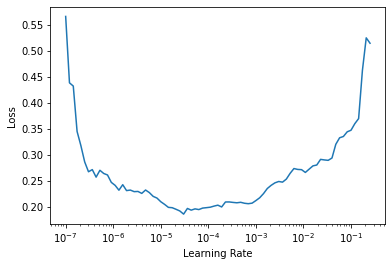

In [33]:
learn.lr_find()

In [34]:
learn.dls = dls_large
learn.unfreeze()
learn.fit(10, slice(1e-6, 1e-4))

KeyboardInterrupt: 

In [35]:
learn.dls = dls

In [36]:
learn.fit(10, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.118050,0.141059,0.945481,0.655743,00:52
1,0.079174,0.136593,0.948225,0.654687,00:52
2,0.069339,0.129031,0.954537,0.635821,00:52
3,0.052341,0.132905,0.954354,0.657808,00:53
4,0.039283,0.124820,0.957647,0.630045,00:53
5,0.028470,0.149691,0.947951,0.661907,00:53
6,0.024937,0.134077,0.956733,0.634486,00:53
7,0.030073,0.136406,0.955635,0.651100,00:53
8,0.021393,0.148851,0.955909,0.678228,00:53
9,0.015341,0.142131,0.956184,0.656287,00:53
